In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from utils import *

def get_demographics_data(only_eyetracking=True):
    df = pd.read_excel("./data/ICUdata/demographics.xlsx")
    df = df[['Participant Number', 'Easy icu A', 'Easy icua A', 'Hard icu B', 'Hard icua B', 'Scores', 'Scores.1', 'Scores.2', 'Scores.3']]
    df = df.rename(columns={"Participant Number": "participant", 'Easy icu A':0, 'Easy icua A':1, 'Hard icu B':2, 'Hard icua B':3, 
                            'Scores' : 'S0', 'Scores.1' : 'S1', 'Scores.2' : 'S2', 'Scores.3' : 'S3'})
    df = df.applymap(lambda x: x.replace(" ", "").replace("'", ""))
    
    if only_eyetracking:
        valid_participants = load_nested_dict('data/Processed').keys()
        df = df[df['participant'].isin(valid_participants)]
    return df

def compute_failure_interval_statistics(data, statistic):
    df = pd.DataFrame(columns=['participant', 'experiment', *sorted(ALL_WINDOW_PROPERTIES.keys()), 'total'])
    for participant, _data1 in data.items():
        for experiment, _data2 in _data1.items():
            start_time, finish_time =  _data2['start_time'], _data2['finish_time']
            stats, all_failure_intervals = [], []
            for task, _data3 in sorted(_data2['tasks'].items()):
                failure_intervals = [compute_time_intervals(x.failure, x.timestamp, start_time, finish_time).intervals for x in _data3.values()]
                failure_intervals = merge_intervals(failure_intervals) # merge them to get failures for a single task
                stats.append(statistic(failure_intervals, start_time, finish_time))
                all_failure_intervals.append(failure_intervals)
            total_failure = merge_intervals(all_failure_intervals) # overlapping total
            total_stat = statistic(total_failure, start_time, finish_time)
            df.loc[len(df)] = [participant, experiment[3:], *stats, total_stat]
    return df

def get_task_counts():
    df = get_demographics_data()
    exp = sorted(df[[0,1,2,3]].melt()['value'].unique())
    def gen():
        for column in df[[0,1,2,3]].columns:
            vcounts = df[column].value_counts().reset_index()
            value_counts = {k:0 for k in exp}
            value_counts.update(dict(zip(vcounts[vcounts.columns[0]], vcounts['count'])))
            yield value_counts
    return pd.DataFrame(gen())

pd.set_option("display.max_rows", 10)


   icuA  icuB  icuaA  icuaB
0     4     5      4      3
1     0     4      3      9
2     6     7      1      2
3     6     0      8      2


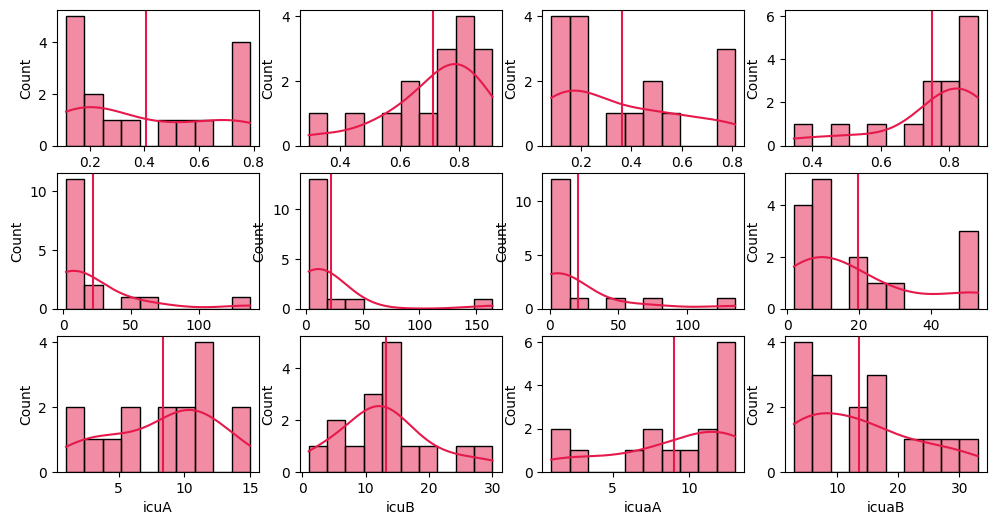

In [40]:
# Visualises performance distributions

def visualise_performance_distribution(df, axes):
    df = df[['participant', 'experiment', 'total']]
    df = df.pivot(index='participant', columns='experiment', values='total')
    exp = df.reset_index(drop=True).select_dtypes(include="number").columns.to_list()
    for c, ax in zip(exp, axes.ravel()):
        sns.histplot(df[c], ax=ax, bins=10, kde=True)
        ax.axvline(x=df[c].mean().item())

data = load_nested_dict('data/Processed') 

df = compute_failure_interval_statistics(data, Statistics.compute_failure_proportion)
exp = df.reset_index(drop=True).select_dtypes(include="number").columns.to_list()
           
fig, axes = plt.subplots(ncols=len(exp), nrows=3, figsize=(12,6))

visualise_performance_distribution(df, axes[0])

# NOTE: this performance is problematic, the distribution has a very long tail... some people did pretty bad! 
df = compute_failure_interval_statistics(data, Statistics.compute_mean_interval_length)
visualise_performance_distribution(df, axes[1])

df = compute_failure_interval_statistics(data, Statistics.compute_failure_count)
visualise_performance_distribution(df, axes[2])


In [192]:
# visualises performance and perceived difficulty 
data = load_nested_dict('data/Processed') 

df_p = compute_failure_interval_statistics(data, Statistics.compute_failure_proportion)
df_p = df_p[['participant', 'experiment', 'total']]
df_p = df_p.pivot(index='participant', columns='experiment', values='total')
exp = df_p.reset_index(drop=True).select_dtypes(include="number").columns.to_list()

# normalise over the population for each task, this may let us see trends more easily.
#df_p[exp] = MinMaxScaler().fit_transform(df_p[exp]) 
# subtract population average for each task, this may let us see trends more easily.
#df_p[exp] = df_p[exp] - df_p[exp].mean()

# these will weight the score by the difficulty (acording to average score) its a correction term as the order distribution is not uniform.
def compute_time_weights(df_p):
    mu = df_p[exp].mean().to_frame().reset_index()
    task_counts = get_task_counts().sort_index(axis=1)
    task_counts.loc[len(task_counts)] = mu[0].to_numpy()
    task_counts = task_counts.iloc[:-1].multiply(task_counts.iloc[-1])
    result = task_counts.sum(axis=1)
    return result / result.sum()
    
weights = compute_time_weights(df_p)

df_demo = get_demographics_data()
df = pd.merge(df_demo[['participant',0,1,2,3]], df_p, on='participant')

def order_score(row):
    row = row.copy()
    row[exp] = [row[exp][exp.index(x)] for x in row[[0,1,2,3]]]
    return row

# order scores by the order they were completed.
df = df.apply(order_score, axis=1) 
df = df.rename(columns={'icuA':'S0', 'icuB':'S1', 'icuaA':'S2', 'icuaB':'S3'})

sco = ['S0', 'S1', 'S2', 'S3']
print(df[sco])
print(df[sco].mean().to_numpy())
# performance, lower is better... I am still hesitant to draw any conclusions.
print(df[sco].mean().to_numpy() / weights.to_numpy())

# NOTE: 4 trials per participant is not really enough to measure a trend.

          S0        S1        S2        S3
0   0.170048  0.140658  0.459953  0.346320
1   0.764953  0.822014  0.874677  0.749124
2   0.294093  0.771296  0.740864  0.416329
3   0.862713  0.812973  0.348942  0.346533
4   0.911663  0.863283  0.635587  0.193593
..       ...       ...       ...       ...
11  0.795597  0.175265  0.623271  0.287987
12  0.560562  0.481855  0.083707  0.126635
13  0.791822  0.728503  0.129862  0.098092
14  0.810646  0.888517  0.766149  0.867995
15  0.474999  0.822959  0.709436  0.761466

[16 rows x 4 columns]
[0.60720572 0.67365391 0.58530448 0.36502344]
[2.43934721 2.24706312 2.250779   1.90871652]


slope: [-0.15881762] intercept: 2.449702888132384


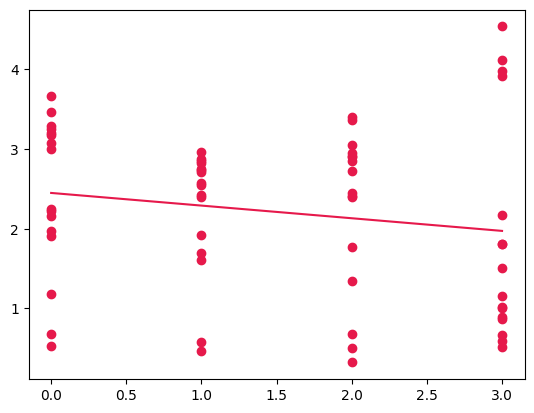

In [193]:
# correction for non-uniform distribution...
x = pd.DataFrame(df[sco].to_numpy().copy() / weights.to_numpy().copy()) 
#x = pd.DataFrame(df[sco].to_numpy().copy())

x = x.melt(var_name='X', value_name='Y')

from sklearn.linear_model import LinearRegression
# Create an instance of the LinearRegression model
x, y = x['X'].to_numpy(), x['Y'].to_numpy()

model = LinearRegression()
model.fit(x[:,np.newaxis], y)
slope = model.coef_
intercept = model.intercept_
print(f"slope: {slope} intercept: {intercept}")

plt.scatter(x,y)

x_line = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_line, slope * x_line + intercept)



In [201]:
pd.set_option('display.max_colwidth', 10000)
pd.set_option("display.max_rows", 40)

df_demo = get_demographics_data()

df_demo.to_csv('output.txt', index=False)



   participant      0      1      2      3        S0        S1        S2   
0          P01   icuA  icuaA   icuB  icuaB     veasy     veasy      easy  \
1          P02   icuA   icuB  icuaB  icuaA     veasy      easy      hard   
2          P03   icuB  icuaB   icuA  icuaA      easy  moderate      easy   
3          P04  icuaB   icuB   icuA  icuaA  moderate      hard      easy   
4          P05   icuB  icuaB   icuA  icuaA  moderate      hard      easy   
..         ...    ...    ...    ...    ...       ...       ...       ...   
16         P17  icuaB  icuaA   icuB   icuA      hard     veasy  moderate   
17         P18   icuB  icuaB  icuaA   icuA  moderate  moderate      easy   
22         P23   icuB  icuaB   icuA  icuaA  moderate  moderate     veasy   
23         P24  icuaA   icuB   icuA  icuaB      hard  moderate  moderate   
24         P25   icuA  icuaB   icuB  icuaA     veasy      hard  moderate   

          S3  
0       easy  
1   moderate  
2       easy  
3       easy  
4       easy

<Axes: >

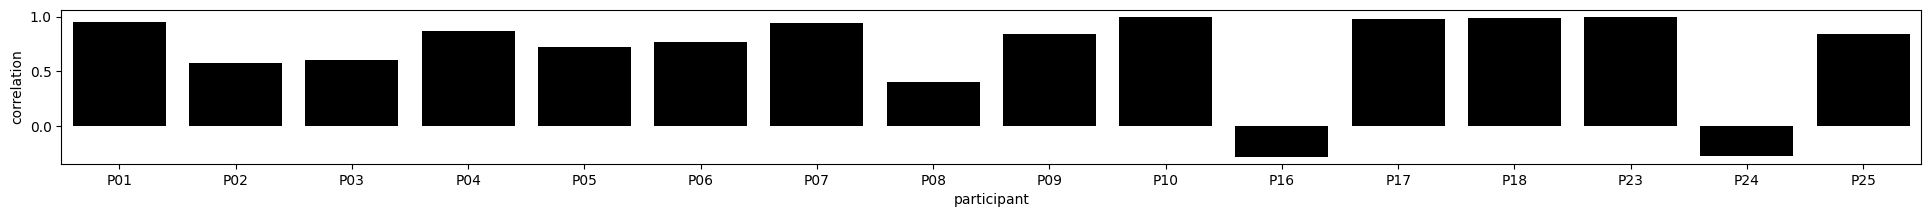

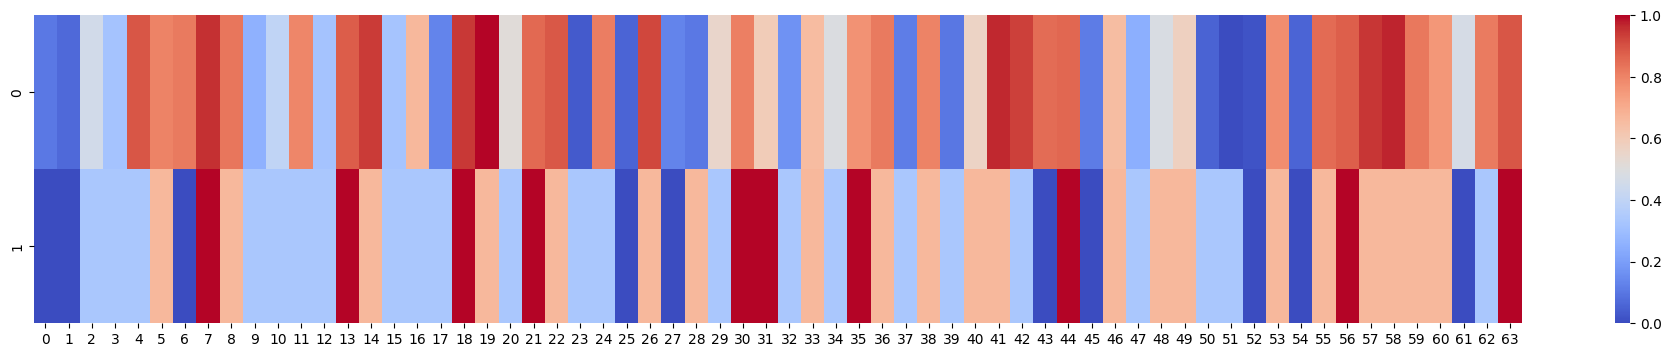

In [194]:
# visualises performance against perceived difficulty 
# Q: did the participants accurately judge difficulty? 
# A: yes, most of them except P16 and P24. Interestingly these are two of the worst performers (especially 24)

# P16, icuaA, icuB, icuaB, icuA,  moderate, easy,     moderate, veasy
# P24, icuaA, icuB, icuA,  icuaB, hard,     moderate, moderate, moderate
# what was P16 doing?


pd.set_option("display.max_rows", 10)

data = load_nested_dict('data/Processed') 

df_p = compute_failure_interval_statistics(data, Statistics.compute_failure_proportion)
#mean_failure_length = compute_failure_interval_statistics(data, Statistics.compute_mean_interval_length)
#failure_count = compute_failure_interval_statistics(data, Statistics.compute_failure_count)

df_demo = get_demographics_data()
df_p = df_p[['participant', 'experiment', 'total']]
df_p = df_p.pivot(index='participant', columns='experiment', values='total')

def reorder_rows(row):
    icrow = row[[0,1,2,3]].tolist()
    index = [icrow.index(i) + 1 for i in df_p.columns]
    ecrow = row[['participant','S0','S1','S2','S3']]
    return ecrow[[0,*index]].reset_index(drop=True)

df_est = df_demo.apply(reorder_rows, axis=1).reset_index(drop=True)
df_p = df_p.reset_index()
df_est.columns = df_p.columns

df_p = df_p.melt(id_vars='participant', var_name='experiment', value_name='score')
df_est = df_est.melt(id_vars='participant', var_name='experiment', value_name='estimate')

df_m = pd.merge(df_p, df_est, on=['participant', 'experiment'])

ests = ['veasy', 'easy', 'moderate', 'hard']
ests = {ests[i]:i for i in range(len(ests))}

df_corr = df_m.replace(ests)

print(f"Overall Correlation: {df_corr['score'].corr(df_corr['estimate']):.4f}")

grouped_df = df_corr.groupby('participant')[['score', 'estimate']].corr().reset_index()
grouped_df = grouped_df.loc[::2][['participant', 'estimate']]
grouped_df = grouped_df.rename(columns={'estimate':'correlation'})


plt.figure(figsize=(24,2))
sns.barplot(x='participant', y='correlation', data=grouped_df, color='black')

plt.figure(figsize=(24,4))
sns.heatmap(MinMaxScaler().fit_transform(df_corr.sort_values('participant').reset_index(drop=True)[['score','estimate']]).T, cmap='coolwarm',)

        0         1  count
0    icuA      easy      9
1   icuaB  moderate      9
2    icuB  moderate      8
3   icuaA      easy      8
4    icuA     veasy      6
5   icuaB      hard      6
6    icuB      easy      5
7   icuaA     veasy      4
8    icuB      hard      3
9   icuaA  moderate      3
10   icuA  moderate      1
11  icuaA      hard      1
12  icuaB      easy      1


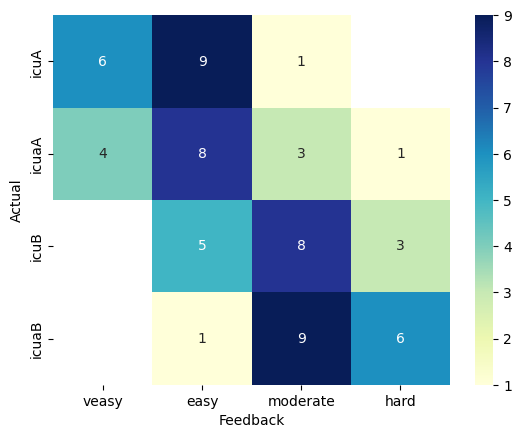

In [195]:
# Visualises actual difficulty and perceived difficulty (via feedback).
# It looks like the agents made things slightly worse here...

df = get_demographics_data()
counts_df = pd.DataFrame(np.concatenate([df[[i, f'S{i}']].to_numpy() for i in range(4)], axis=0))
pd.set_option("display.max_rows", 1000)
counts_df = pd.DataFrame(counts_df.value_counts()).reset_index()
print(counts_df)

# Pivot the dataframe to create a matrix-like structure
heatmap_data = counts_df.pivot(columns=1, index=0, values='count')
heatmap_data.fillna(0)
heatmap_data = heatmap_data[['veasy', 'easy', 'moderate', 'hard']]
heatmap_data = heatmap_data.reindex(['icuA','icuaA','icuB', 'icuaB'])

# Create the heatmap using seaborn
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")

# Set the labels for the x-axis and y-axis
plt.xlabel('Feedback')
plt.ylabel('Actual')

# Display the heatmap
plt.show()

In [ ]:
X = df_p.melt(id_vars='participant', var_name='experiment', value_name='score')
